In [1]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

cuda:0


In [27]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import plate_modules
from plate_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *


import importlib
plate_modules=importlib.reload(plate_modules)
from plate_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



In [3]:
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvM_900k_RPCA_clusters.h5ad'))
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part1.h5ad'),backed='r+')
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall.h5ad'),backed='r+')
"""
species_arg=adata.obs['species'].cat.codes
species_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['species'].cat.codes).long(),num_classes=len(adata.obs['species'].cat.categories)).float()

adata.uns['batch_cats']=dict(zip([str(x) for x in adata.obs['batch_name'].cat.categories],[str(x) for x in sorted(set(adata.obs['batch_name'].cat.codes))]))
batch_arg=adata.obs['batch_name'].replace(adata.uns['batch_cats']).astype(int)
batch_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['batch_name'].replace(adata.uns['batch_cats']).astype(int)).long(),
                                         num_classes=len(adata.uns['batch_cats'].keys())).float()


adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]#.todense()
#adata=adata[np.random.choice(adata.obs.index,100000,replace=False),:]
#sc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",subset=True)

adata=adata[~adata.obs.general_region.isin(['Cultured']),:]
adata=adata[~adata.obs.batch_name.str.contains('P10'),:]
#adata=adata[adata.obs['general_region'].isin(['bn','cp','ctx','ge']),:]

adata.obs['species']=adata.obs['species'].astype('category')
sc.pl.umap(adata,color=['species'])
sc.pl.umap(adata,color=['leiden'],legend_loc="on data")
sc.pl.umap(adata,color='region')
adata.obsm['X_original_umap']=adata.obsm['X_umap']
adata.obs['n_counts']=adata.X.sum(1)
"""

'\nspecies_arg=adata.obs[\'species\'].cat.codes\nspecies_values=torch.nn.functional.one_hot(torch.tensor(adata.obs[\'species\'].cat.codes).long(),num_classes=len(adata.obs[\'species\'].cat.categories)).float()\n\nadata.uns[\'batch_cats\']=dict(zip([str(x) for x in adata.obs[\'batch_name\'].cat.categories],[str(x) for x in sorted(set(adata.obs[\'batch_name\'].cat.codes))]))\nbatch_arg=adata.obs[\'batch_name\'].replace(adata.uns[\'batch_cats\']).astype(int)\nbatch_values=torch.nn.functional.one_hot(torch.tensor(adata.obs[\'batch_name\'].replace(adata.uns[\'batch_cats\']).astype(int)).long(),\n                                         num_classes=len(adata.uns[\'batch_cats\'].keys())).float()\n\n\nadata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]#.todense()\n#adata=adata[np.random.choice(adata.obs.index,100000,replace=False),:]\n#sc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",subset=True)\n\nadata=adata[~adata.obs.general_region.isin([\'Cultured\']),:]

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


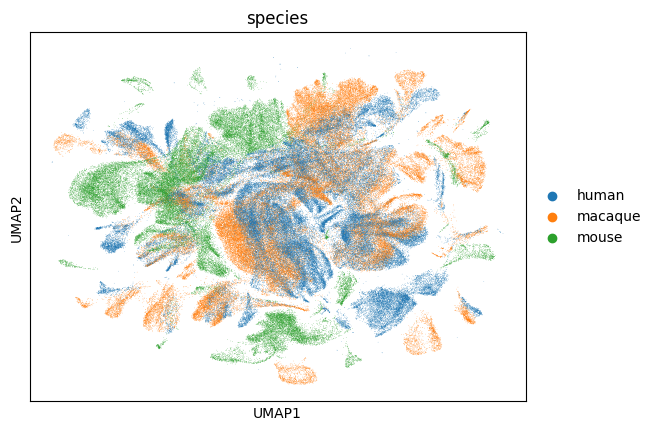

In [4]:
adata.obsm["X_original_umap"]=adata.obsm["X_umap"]
sc.pl.umap(adata,color='species')

<Axes: xlabel='general_region'>

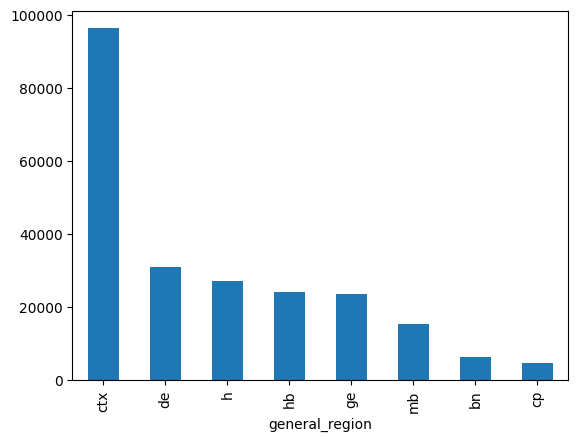

In [5]:
adata.obs['general_region'].value_counts().plot.bar()
#adata.obs['sample_region'].value_counts().plot.bar()
#adata.obs.groupby('species')['sample_region'].value_counts(normalize=True).unstack().T.plot.bar()

# Setting up the model

In [38]:
from scvi.module.base import PyroBaseModuleClass

class ANTIPODE(PyroBaseModuleClass):
    """
    ANTIPODE is a variational inference model that is developed for the analysis and 
    categorization of cell types across evolution based on single-cell data. 

    Parameters:
    num_var (int): Number of variables (features) in the dataset.
    level_sizes (list of int, optional): Sizes of each level in the model's hierarchical structure. 
                                         Defaults to [1, 10, 20, 50].
    num_latent (int, optional): Number of latent dimensions. Defaults to 10.
    alpha (float, optional): The Dirichlet concentration parameter. Defaults to 0.01.
    scale_factor (float, optional): Scaling factor for data normalization. Defaults to 1.0.
    num_species (int, optional): Number of species (or groups) in the dataset. Defaults to 1.
    num_batch (int, optional): Number of batches to correct for in the data. Defaults to 1.
    prior_scale (float, optional): Scale of the laplace prior distributions. Defaults to 100.
    bi_depth (int, optional): Depth of the tree for the approximation of batch by identity effects. Defaults to 2.

    """
    def __init__(self, num_var,level_sizes=[1,10,20,50],
                 num_latent=10, alpha=0.01, scale_factor=1.0,
                 num_species=1,num_batch=1,prior_scale=100,
                 decay_function=None,max_strictness=1.,bi_depth=2,num_batch_embed=10):
        
        self._setup_adata_manager_store: dict[
            str, type[scvi.data.AnnDataManager]
        ] = {}
        self.num_var = num_var
        self.num_species = num_species
        self.num_batch = num_batch
        self.num_latent = num_latent
        self.scale_factor=scale_factor
        self.level_sizes=level_sizes
        self.num_labels = np.sum(self.level_sizes)
        self.level_indices=np.cumsum([0]+self.level_sizes)
        #how deep in the tree should batch by identity be accounted for
        self.bi_depth=bi_depth
        self.num_bi_depth=sum(self.level_sizes[:self.bi_depth])
        self.num_batch_embed=num_batch_embed
        self.max_strictness=1.
        self.decay_function=decay_function
        self.design_matrix=False #Can be fed multi-hot batch/species with serious performance hit
        self.temperature=0.1
        
        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.species_plate=pyro.plate('species_plate',self.num_species,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)
        self.bi_depth_plate=pyro.plate('bi_depth_plate',self.num_bi_depth,dim=-2)

        #Initialize MAP inference modules
        self.dm=MAPLaplaceModule(self,'species_dm',[self.num_species,self.num_labels,self.num_latent],[self.species_plate,self.label_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch,self.num_labels,self.num_latent],[self.batch_plate,self.label_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'species_di',[self.num_species,self.num_labels,self.num_var],[self.species_plate,self.label_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.num_bi_depth,self.num_var],[self.batch_embed_plate,self.bi_depth_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_labels, self.num_var],[self.label_plate,self.var_plate])
        self.dc=MAPLaplaceModule(self,'species_dc',[self.num_species,self.num_latent,self.num_var],[self.species_plate,self.latent_plate2,self.var_plate])
        #Just params (ML inference)
        self.zdw=MAPLaplaceModule(self,'z_decoder_weight',[self.num_latent,self.num_var],[self.latent_plate2,self.var_plate],init_val=((2/self.num_latent)*(torch.rand(self.num_latent,self.num_var)-0.5)),param_only=True)
        self.zl=MAPLaplaceModule(self,'locs',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=True)
        self.zs=MAPLaplaceModule(self,'scales',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],init_val=0.01*torch.ones(self.num_labels,self.num_latent),constraint=constraints.positive,param_only=True)
        self.zld=MAPLaplaceModule(self,'locs_dynam',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=True)
        
        self.tree_edges=TreeEdges(self,straight_through=True)
        self.tree_convergence=TreeConvergence(self,strictness=1.)        
        self.tree_convergence_bottom_up=TreeConvergenceMaxBottomUp(self,strictness=1.)        
        self.z_transform=null_function#centered_sigmoid#torch.special.expit
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=num_var,hidden_dims=[6000,3000,1000],num_cat_input=self.num_species,
                    outputs=[(self.num_latent,None),(self.num_latent,softplus)])
        
        self.classifier=Classifier(num_latent=self.num_latent,
                    outputs=[(self.num_labels,None),(1,None),(1,softplus)])

        #self.bc_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[200,200,50,5],
        #            out_dim=self.num_var*self.num_latent)
        #Too large to exactly model gene-level batch effects for all cluster x batch
        self.be_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[1000,500,200],
                    out_dim=self.num_batch_embed)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        #Whether to approximate tree connectivity during approximation mode
        self.prior_scale=prior_scale
        self.args=inspect.getfullargspec(self.model).args[1:]#skip self

    def setup_anndata(self,adata: anndata.AnnData,fields,field_types,**kwargs,):
        
        anndata_fields=[make_field(x,fields[x]) for x in fields.keys()]
        
        adata_manager = scvi.data.AnnDataManager(
            fields=anndata_fields
        )
        adata_manager.register_fields(adata, **kwargs)
        self.register_manager(adata_manager)
        if fields['species_ind'][0]=='obsm':
            self.design_matrix=True
            if fields['batch_ind'][0]!='obsm':
                raise Exception("If species is design matrix, batch must be as well!")


    def register_manager(self, adata_manager: scvi.data.AnnDataManager):
        adata_id = adata_manager.adata_uuid
        self._setup_adata_manager_store[adata_id] = adata_manager
        self.adata_manager=adata_manager
    
    def set_approx(self,b: bool):
        self.approx=b
        
    def model(self, s,species_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)

        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            species=index_to_onehot(species_ind,[s.shape[0],self.num_species]).to(s.device)
            batch_ind=batch_ind.squeeze()
            species_ind=species_ind.squeeze()
        else:
            batch=batch_ind
            species=species_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0],dim=-1)
        minibatch_plate2=pyro.plate("minibatch_plate2", s.shape[0],dim=-2)
        cur_strictness=self.decay_function(step, self.max_strictness)
        l = s.sum(1).unsqueeze(-1)
        
        with poutine.scale(scale=self.scale_factor):
            # This gene-level parameter modulates the variance of the observation distribution
            s_theta = pyro.param("s_inverse_dispersion", 50.0 * s.new_ones(self.num_var),
                               constraint=constraints.positive)
            
            scd=pyro.param("species_constitutive_de", s.new_zeros((self.num_species,self.num_var)))
            level_edges=self.tree_edges.model_sample(s,approx=self.approx)
            
            # We scale all sample statements by scale_factor so that the ELBO loss function
            # is normalized wrt the number of datapoints and genes.
            # This helps with numerical stability during optimization.
            with minibatch_plate:
                beta_prior_a=1.*s.new_ones(self.num_labels)
                beta_prior_a[0]=10.
                if self.approx:#Bernoulli particles approx?
                    taxon = pyro.sample("taxon_probs", dist.Beta(beta_prior_a,s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=taxon).to_event(1))
                    #self.tree_convergence.model_sample(taxon,level_edges,s,cur_strictness)
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Dirichlet(s.new_ones(s.shape[0],self.level_sizes[-1]),validate_args=True))
                    if sum(taxon.shape) > 1:#Supervised?
                        if taxon.shape[-1]==self.num_labels:#Totally supervised?
                            pass
                        else:#Only bottom layer is supervised?
                            taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),obs=taxon)
                            taxon = torch.concat(self.tree_convergence_bottom_up.model_sample(taxon,level_edges,s),-1)
                    else:#Unsupervised
                        taxon = pyro.sample("taxon", model_distributions.SafeAndRelaxedOneHotCategoricalStraightThrough(temperature=self.temperature*s.new_ones(1),probs=taxon_probs,validate_args=True))
                        taxon = torch.concat(self.tree_convergence_bottom_up.model_sample(taxon,level_edges,s),-1)
                   
            locs=self.zl.model_sample(s)
            scales=self.zs.model_sample(s)
            locs_dynam=self.zld.model_sample(s)
            species_dm=self.dm.model_sample(s,scale=fest([species,taxon],-1))
            species_di=self.di.model_sample(s,scale=fest([species,taxon],-1))
            batch_dm=self.bm.model_sample(s,scale=fest([batch,taxon],-1))
            bei=self.bei.model_sample(s,scale=fest([s.new_ones(s.shape[0],self.num_batch_embed),taxon[...,:self.num_bi_depth]],-1))
            cluster_intercept=self.ci.model_sample(s,scale=fest([taxon],-1))
            z_decoder_weight=self.zdw.model_sample(s)
            
            with minibatch_plate:
                bi=torch.einsum('bi,ijk->bjk',self.be_nn(batch),bei)
                bi=torch.einsum('bj,bjk->bk',taxon[...,:self.num_bi_depth],bi)
                psi = pyro.sample('psi',dist.Laplace(s.new_zeros(s.shape[0],1),self.prior_scale*s.new_ones(s.shape[0],1)).to_event(1))#Used to be normal#maybe should be centered sigmoid
                this_locs=oh_index(locs,taxon)
                this_scales=oh_index(scales,taxon)
                z=pyro.sample('z', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))

            cur_species_dm = oh_index1(species_dm, species_ind) if self.design_matrix else species_dm[species_ind]
            cur_batch_dm = oh_index1(batch_dm, batch_ind) if self.design_matrix else batch_dm[batch_ind]
            cur_scd = oh_index(scd, species) if self.design_matrix else  scd[species_ind]
            
            z=z+oh_index2(cur_species_dm,taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)                
            
            species_dc=self.dc.model_sample(s,scale=fest([species,z.abs()],-1))
            cur_species_di = oh_index1(species_di, species_ind) if self.design_matrix else species_di[species_ind]
            cur_species_dc = oh_index1(species_dc, species_ind) if self.design_matrix else species_dc[species_ind]
            cur_species_di=oh_index2(cur_species_di,taxon)
            cur_cluster_intercept=oh_index(cluster_intercept,taxon)
            
            mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+cur_species_dc)#+bc
            spliced_mu=mu+cur_scd+cur_species_di+cur_cluster_intercept+bi
            spliced_out=torch.softmax(spliced_mu,dim=-1)
            log_mu = (l * spliced_out + 1e-6).log()
            
            with self.var_plate,minibatch_plate2:
                s_dist = dist.NegativeBinomial(total_count=s_theta,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist, obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s,species_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        pyro.module("antipode", self)
        
        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            species=index_to_onehot(species_ind,[s.shape[0],self.num_species]).to(s.device)
            batch_ind=batch_ind.squeeze()
            species_ind=species_ind.squeeze()
        else:
            batch=batch_ind
            species=species_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0])
        cur_strictness=self.decay_function(step, self.max_strictness)
        
        with poutine.scale(scale=self.scale_factor):
            locs=self.zl.guide_sample(s)
            scales=self.zs.guide_sample(s)
            locs_dynam=self.zld.guide_sample(s)
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx) 
            with minibatch_plate:
                z_loc, z_scale= self.zl_encoder(s,species)
                z=pyro.sample('z',dist.Normal(z_loc,z_scale+self.epsilon).to_event(1))
                z=self.z_transform(z)
                taxon_logits,psi_loc,psi_scale=self.classifier(z)
                psi=pyro.sample('psi',dist.Normal(psi_loc,psi_scale).to_event(1))
                if self.approx:
                    taxon_dist = dist.Delta(safe_sigmoid(taxon_logits),validate_args=True).to_event(1)
                    taxon = pyro.sample("taxon_probs", taxon_dist)
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=taxon).to_event(1))
                    #self.tree_convergence.guide_sample(taxon,level_edges,s,cur_strictness)
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Delta(safe_softmax(taxon_logits[...,-self.level_sizes[-1]:])).to_event(1))
                    if sum(taxon.shape) > 1:
                        pass
                    else:
                        taxon = pyro.sample("taxon", 
                                         model_distributions.SafeAndRelaxedOneHotCategoricalStraightThrough(temperature=self.temperature*s.new_ones(1),probs=taxon_probs,validate_args=True))
                    if taxon.shape[-1]<self.num_labels:
                        taxon = torch.concat(self.tree_convergence_bottom_up.guide_sample(taxon,level_edges,s),-1)

            z_decoder_weight=self.zdw.guide_sample(s)
            species_dm=self.dm.guide_sample(s,scale=fest([species,taxon],-1))
            batch_dm=self.bm.guide_sample(s,scale=fest([batch,taxon],-1))
            species_di=self.di.guide_sample(s,scale=fest([species,taxon],-1))
            cluster_intercept=self.ci.guide_sample(s,scale=fest([taxon],-1))
            bei=self.bei.guide_sample(s,scale=fest([s.new_ones(s.shape[0],self.num_batch_embed),taxon[...,:self.num_bi_depth]],-1))#maybe should be abs sum bei
            if self.design_matrix:
                z=z+oh_index2(oh_index1(species_dm,species_ind),taxon) + oh_index2(oh_index1(batch_dm,batch_ind),taxon)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(species_dm[species_ind],taxon) + oh_index2(batch_dm[batch_ind],taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)
            species_dc=self.dc.guide_sample(s,scale=fest([species,z.abs()],-1))


In [39]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

# Training Phase 1: Particlized tree approximation

In [40]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import plate_modules
from plate_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *


import importlib
plate_modules=importlib.reload(plate_modules)
from plate_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



In [41]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,25,75,250]
num_latent=200
num_labels=sum(level_sizes)
steps=0
max_steps=20000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(True)

decay_function=gen_linear_function(max_steps,10000)#gen_exponential_decay(5e-6)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_var=num_var, num_latent=num_latent,level_sizes=level_sizes,
                num_species=len(adata.obs['species'].unique()),
                num_batch=len(adata.obs['batch_name'].unique()),
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),
                bi_depth=2,decay_function=decay_function,max_strictness=50,prior_scale=10000.,num_batch_embed=10)


scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})
elbo = pyro.infer.JitTrace_ELBO(num_particles=1,strict_enumeration_warning=False)
svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

In [42]:
"""
#For weighted sampler
class_weights = adata.obs['region_species'].astype('category').cat.codes.value_counts(normalize=False,sort=False).sort_index()
labels = list(adata.obs['region_species'].astype('category').cat.codes) #corresponding labels of samples
weights = [1/class_weights[labels[i]] for i in range(len(labels))]
sampler = torch.utils.data.sampler.WeightedRandomSampler(torch.DoubleTensor(weights),len(weights),replacement=True)
"""

design_matrix=False  #3x faster if false
if design_matrix:
    #Place complex batch and categorical covariate (design matrix) in obsm, else use obs categorical
    adata.obsm['species_onehot']=numpy_onehot(adata.obs['species'].cat.codes)
    adata.obsm['batch_onehot']=numpy_onehot(adata.obs['batch_name'].cat.codes)
    fields={'s':('layers','spliced'),
    'species_ind':('obsm','species_onehot'),
    'batch_ind':('obsm','batch_onehot')}
    field_types={"s":np.float32,"batch_ind":np.float32,"species_ind":np.float32}
else:
    adata.obsm['species_onehot']=numpy_onehot(adata.obs['species'].cat.codes)
    adata.obsm['batch_onehot']=numpy_onehot(adata.obs['batch_name'].cat.codes)
    fields={'s':('layers','spliced'),
    'species_ind':('obs','species'),
    'batch_ind':('obs','batch_name')}
    field_types={"s":np.float32,"batch_ind":np.int64,"species_ind":np.int64}

antipode_model.setup_anndata(adata,fields,field_types)
dataloader=scvi.dataloaders.AnnDataLoader(antipode_model.adata_manager,batch_size=32,drop_last=True,shuffle=True,data_and_attributes=field_types)#supervised_field_types for supervised step 

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 0 in adata.obs['_scvi_batch_ind'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [43]:
antipode_model.train()
antipode_model.zl_encoder.train()

antipode_model=antipode_model.to(device)
antipode_model.set_approx(False)
loss_tracker=[]
#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for x in dataloader:
        x['step']=torch.ones(1).to(device)*steps
        #x={k:x[k].to(device) for k in x.keys()}
        x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in antipode_model.args]
        loss=svi.step(*x)
        steps+=1
        if steps<max_steps-1:
            scheduler.step()
        else:
            break
        pbar.update(1)
        loss_tracker.append(loss)
        if not done:
            done=True
            print('grad tracking')
            gradient_norms = defaultdict(list)
            for name, value in pyro.get_param_store().named_parameters():
                value.register_hook(
                    lambda g, name=name: gradient_norms[name].append(g.norm().item())
                )
        if steps%print_every == 0:
            # Tell the scheduler we've done one epoch.
            pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

  2%|▏         | 433/20000 [02:39<2:00:16,  2.71it/s]
/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/model_functions.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/model_functions.py:260: TracerWarning: Co

tensor([[4.7020e-38, 3.5265e-38, 4.7020e-38,  ..., 1.0000e+00, 3.5265e-38,
         5.8775e-38],
        [4.7020e-38, 3.5265e-38, 4.7020e-38,  ..., 4.7020e-38, 3.5265e-38,
         5.8775e-38],
        [4.7020e-38, 3.5265e-38, 4.7020e-38,  ..., 4.7020e-38, 3.5265e-38,
         5.8775e-38],
        ...,
        [4.7020e-38, 3.5265e-38, 4.7020e-38,  ..., 4.7020e-38, 3.5265e-38,
         5.8775e-38],
        [4.7020e-38, 3.5265e-38, 4.7020e-38,  ..., 4.7020e-38, 3.5265e-38,
         5.8775e-38],
        [4.7020e-38, 3.5265e-38, 4.7020e-38,  ..., 4.7020e-38, 3.5265e-38,
         5.8775e-38]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.0000e+00, 1.1755e-38,
         1.1755e-38],
        [1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-38, 1.1755e-38,
         1.1755e-38],
        [1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-38, 1.1755e-38,
         1.1755e-38],
        ...,
        [1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-3

/scratch/fast/14173829/ipykernel_94915/577273692.py:242: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(taxon.shape) > 1:
/scratch/fast/14173829/ipykernel_94915/577273692.py:247: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if taxon.shape[-1]<self.num_labels:
/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This m

tensor([[5.8775e-38, 9.4040e-38, 7.0530e-38,  ..., 3.5265e-38, 7.0530e-38,
         5.8775e-38],
        [5.8775e-38, 9.4040e-38, 7.0530e-38,  ..., 3.5265e-38, 7.0530e-38,
         5.8775e-38],
        [5.8775e-38, 9.4040e-38, 7.0530e-38,  ..., 3.5265e-38, 7.0530e-38,
         5.8775e-38],
        ...,
        [5.8775e-38, 9.4040e-38, 7.0530e-38,  ..., 3.5265e-38, 7.0530e-38,
         5.8775e-38],
        [5.8775e-38, 9.4040e-38, 7.0530e-38,  ..., 3.5265e-38, 7.0530e-38,
         5.8775e-38],
        [5.8775e-38, 9.4040e-38, 7.0530e-38,  ..., 3.5265e-38, 7.0530e-38,
         5.8775e-38]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-38, 1.1755e-38,
         1.1755e-38],
        [1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-38, 1.1755e-38,
         1.1755e-38],
        [1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-38, 1.1755e-38,
         1.1755e-38],
        ...,
        [1.1755e-38, 1.1755e-38, 1.1755e-38,  ..., 1.1755e-3

  0%|          | 1/20000 [00:01<6:26:01,  1.16s/it]

grad tracking


  0%|          | 14/20000 [00:03<35:46,  9.31it/s] 
KeyboardInterrupt



<Axes: >

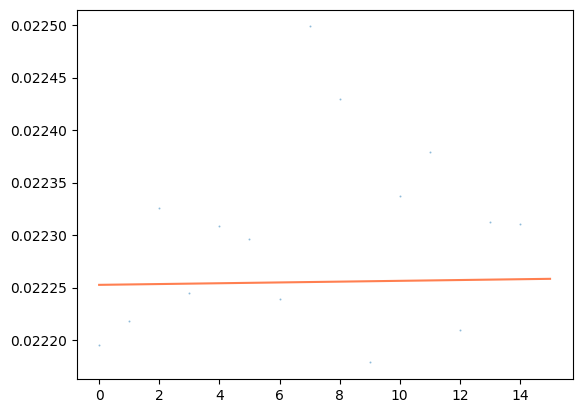

In [44]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



  0%|          | 15/20000 [00:18<35:46,  9.31it/s]

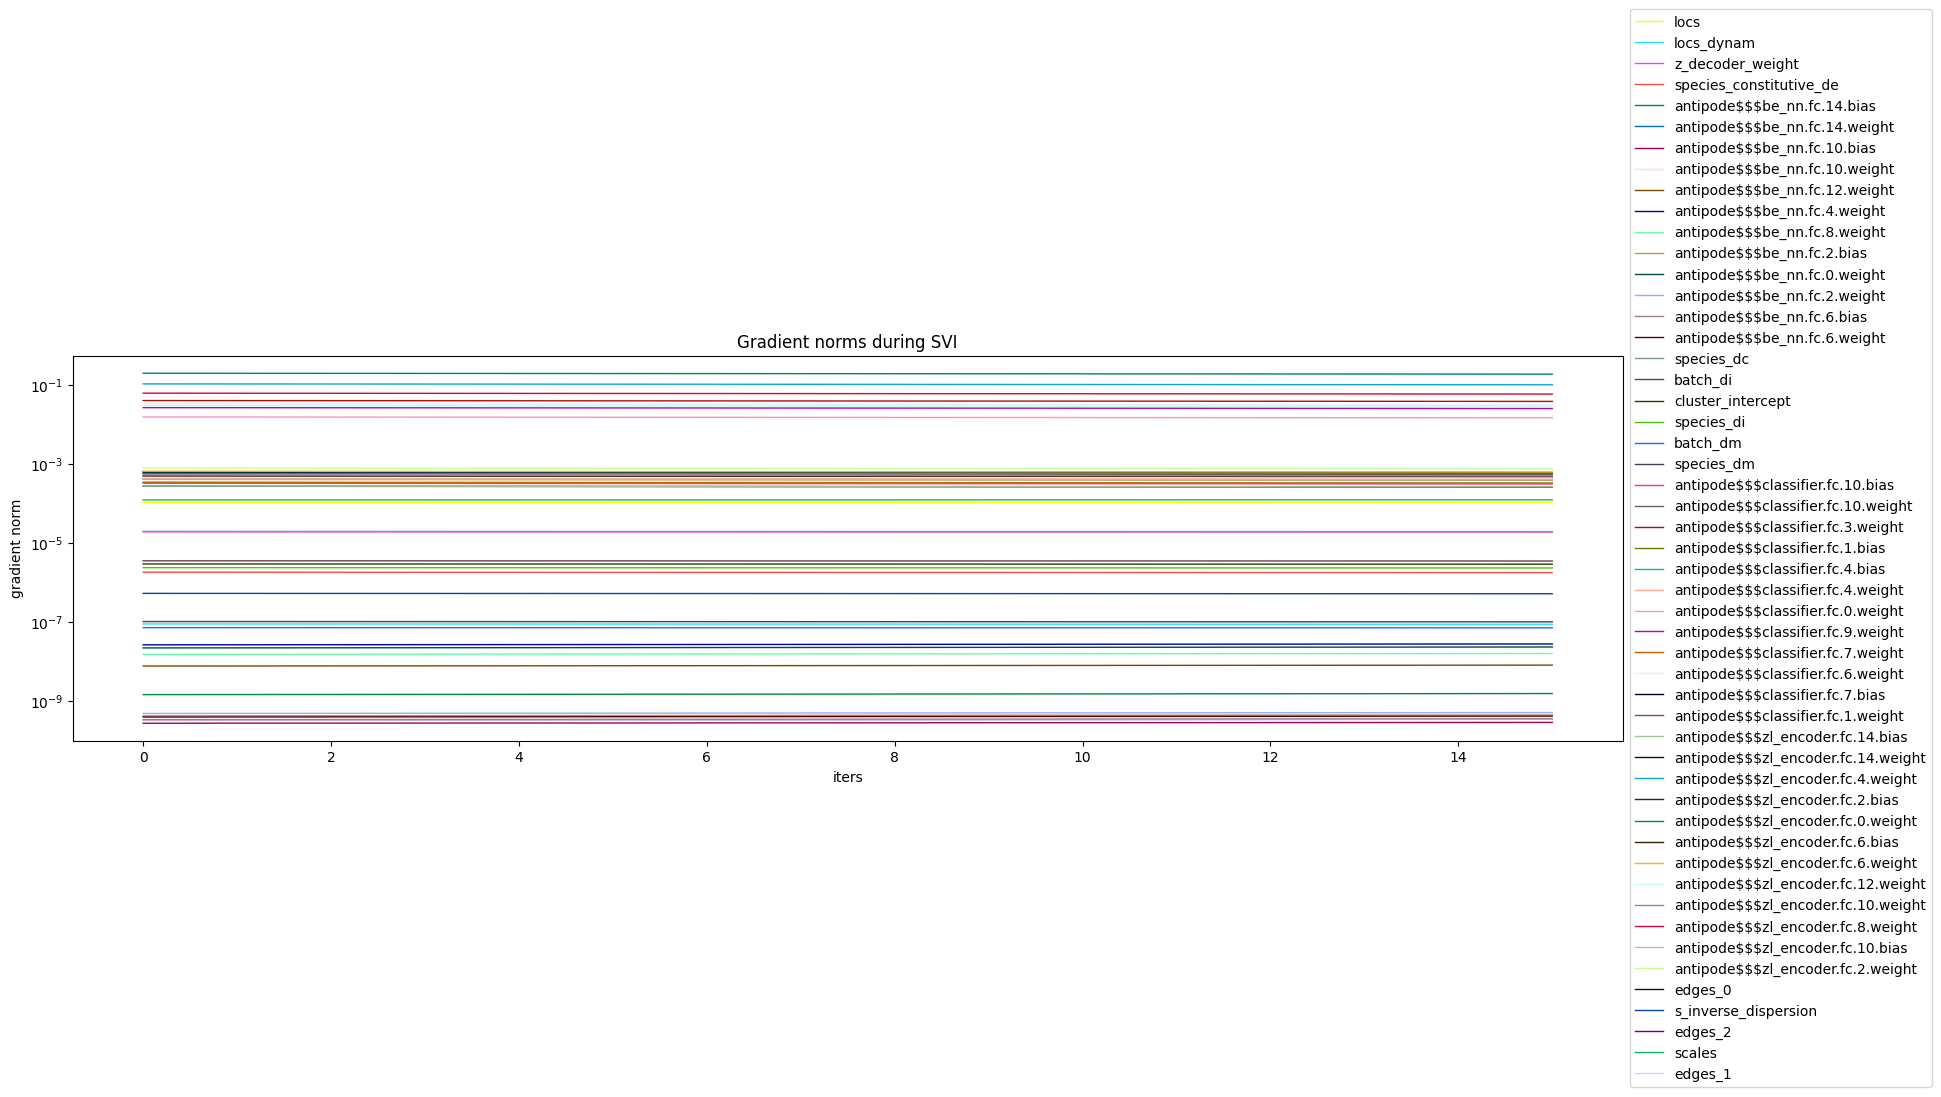

In [45]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [46]:
antipode_model.adata_manager.adata.uns['param_store']=param_store_to_numpy()

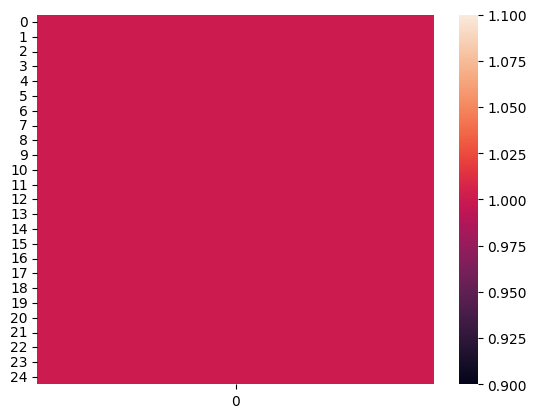

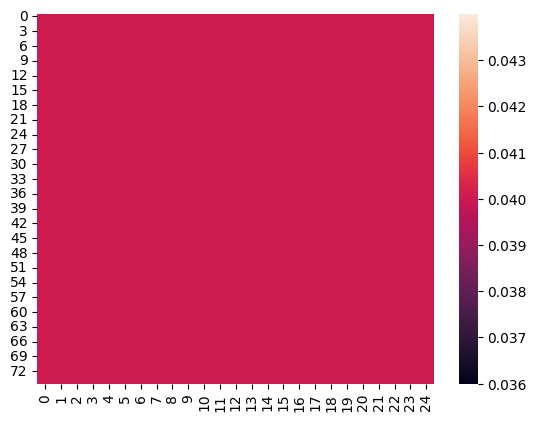

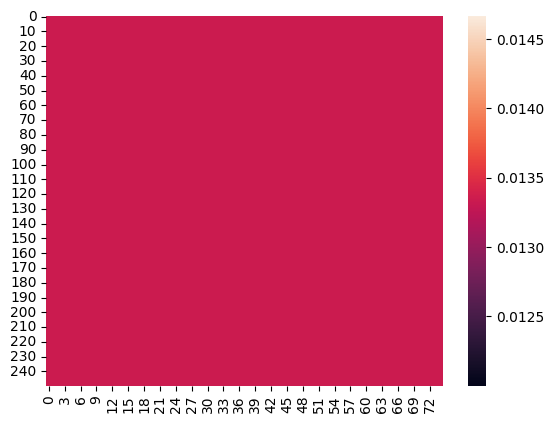

In [47]:
plot_tree_edge_weights(antipode_model)

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


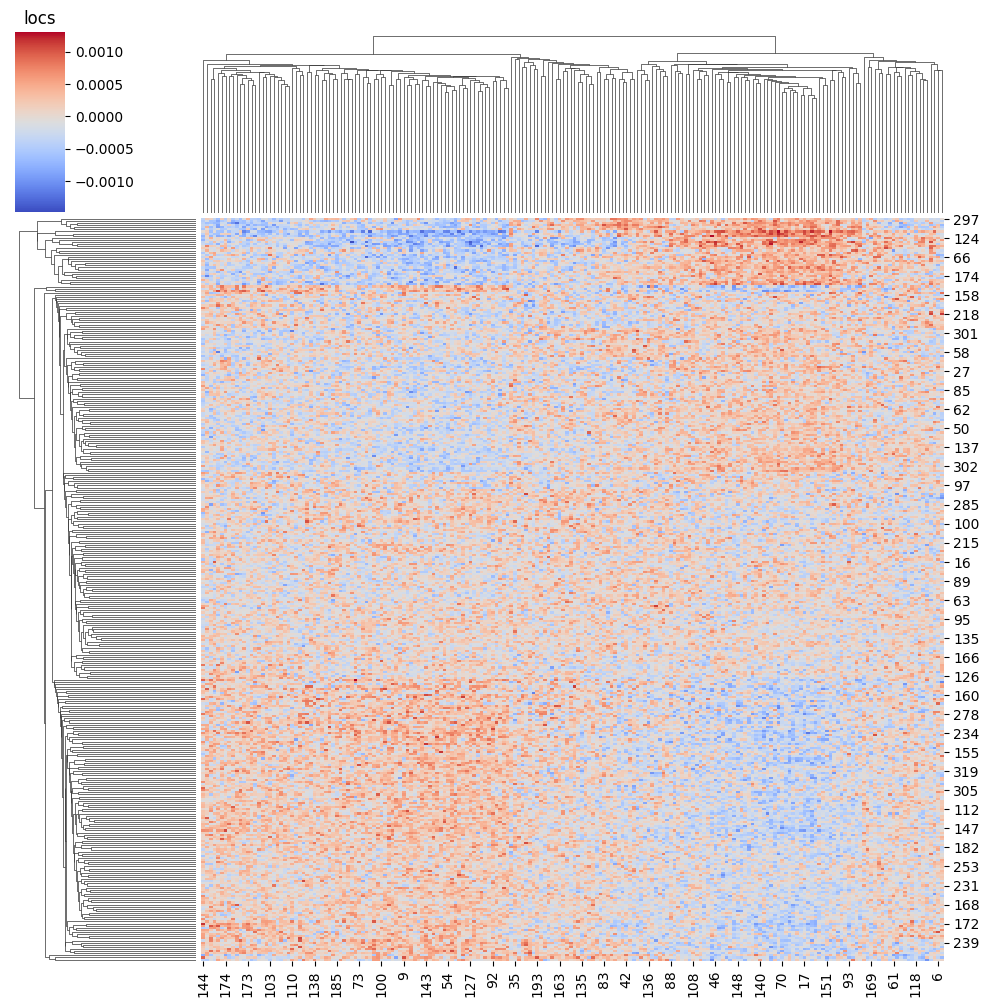

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


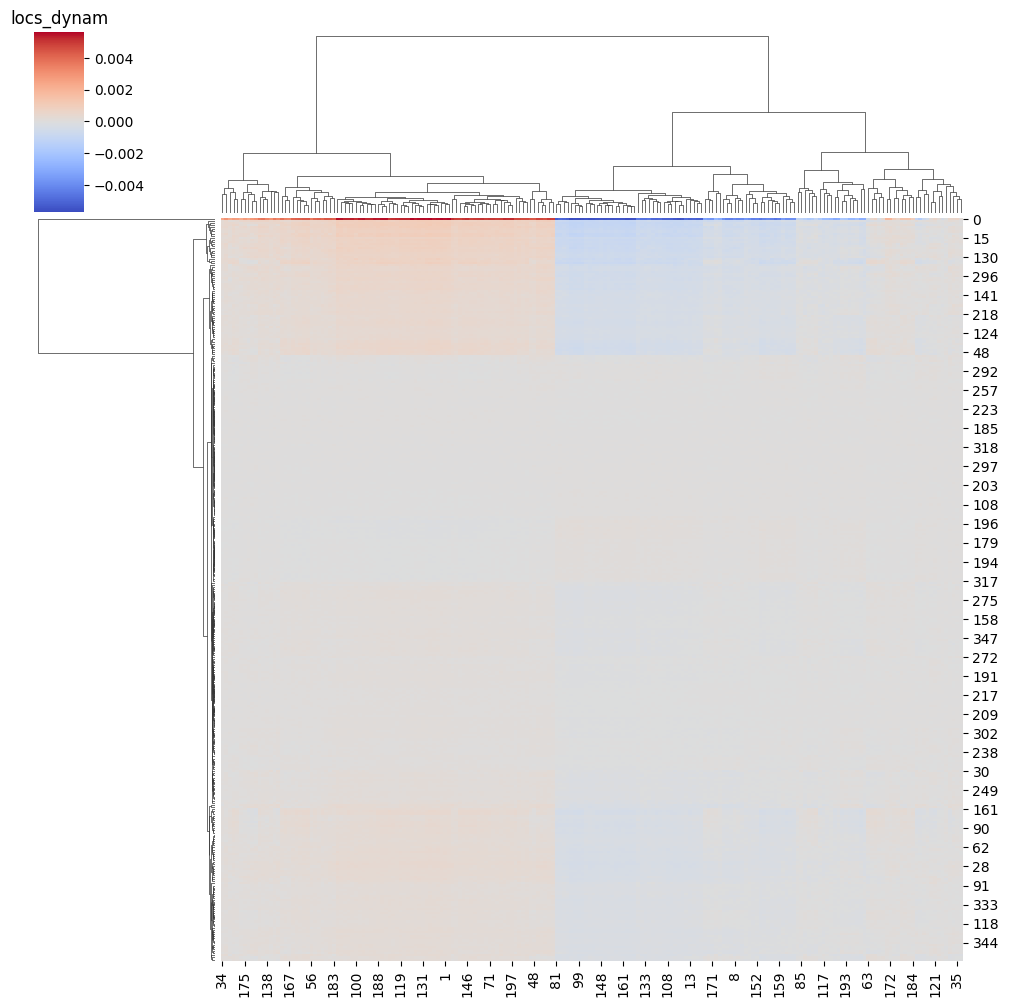

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


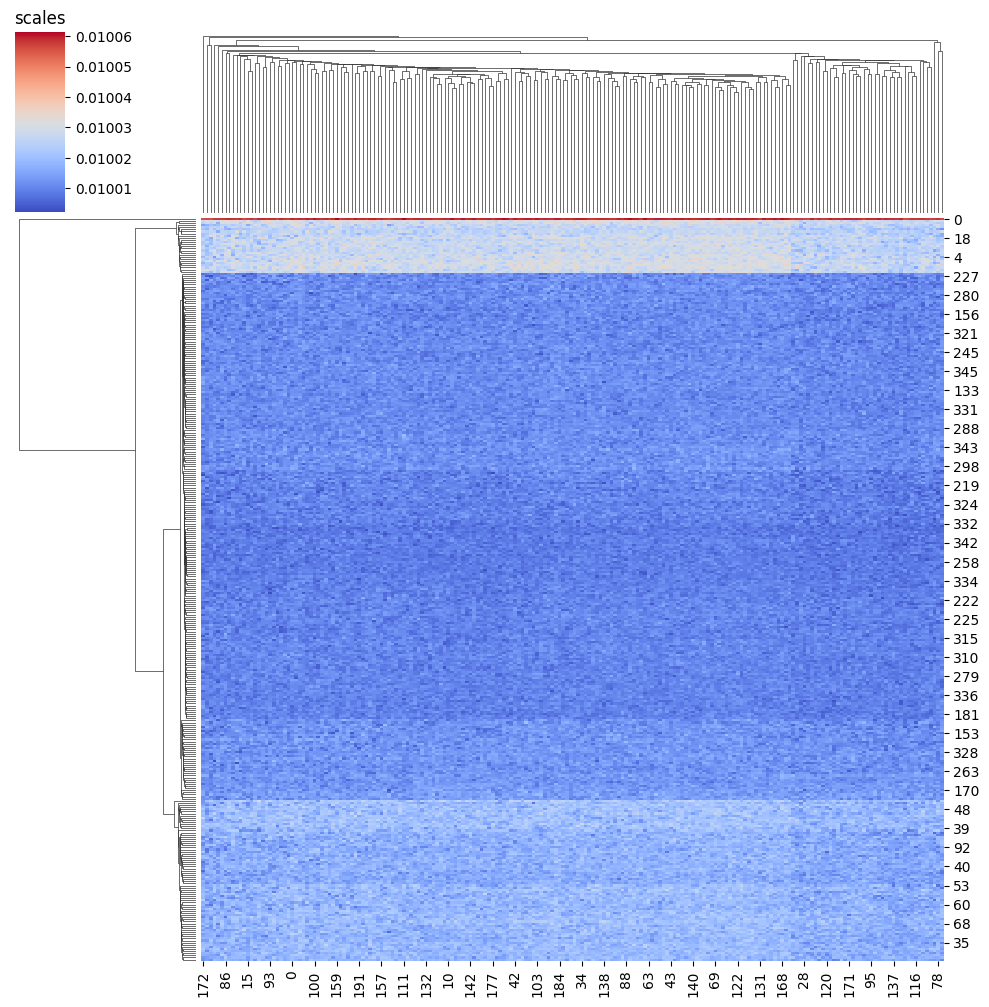

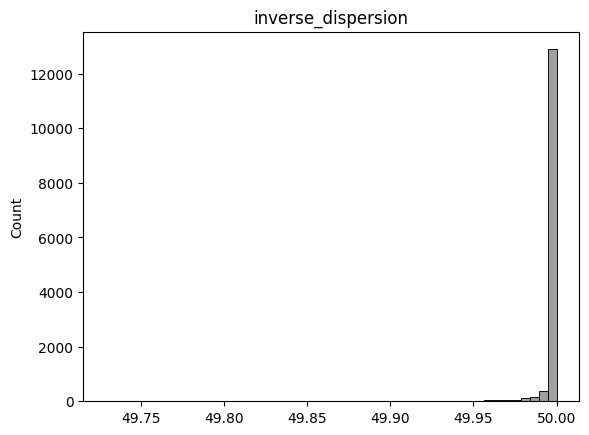

  2%|▏         | 433/20000 [00:38<15:11, 21.47it/s]

In [37]:
plot_gmm_heatmaps(antipode_model)

In [ ]:
plot_d_hists(antipode_model)

In [ ]:
# Put the neural networks in evaluation mode (needed because of batch norm)
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_antipode_outputs(antipode_model,batch_size=2048,device=device)

In [ ]:
clusternames=[str(i) for i in range(antipode_model.num_latent)]
adata.obs['max_component']=np.array(clusternames)[antipode_outs[0][0].argmax(1)]

adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
sc.pl.umap(adata,color=['max_component'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
seaborn.clustermap(np.corrcoef(antipode_outs[0][0].T))

In [ ]:
taxon=antipode_outs[1][0]

nottree_levels = [taxon[..., antipode_model.level_indices[i]:antipode_model.level_indices[i + 1]]
          for i in range(len(antipode_model.level_sizes))]

for i, level in enumerate(nottree_levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the nottree_levels to form the cluster label
adata.obs['antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(nottree_levels))]), axis=1)

level_edges=[scipy.special.softmax(adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    adata.obs['prop_level_'+str(i)]=levels[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['level_'+str(i)].astype(str)

prop_taxon=np.concatenate(levels,axis=-1)
adata.obs['prop_antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(levels))]), axis=1)

sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

seaborn.clustermap(prop_taxon[:10000,:],row_cluster=False)

In [ ]:
adata.obsm['X_antipode_model']=antipode_outs[0][0]
adata.obs['psi']=antipode_outs[1][1]
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode_model")
sc.tl.umap(xdata)

In [ ]:
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:

xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 2: Inintializing categorical leaved tree

In [ ]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=antipode_model.level_sizes[-1],init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(antipode_model.adata_manager.adata.obsm['X_antipode_model'])
adata.obs['kmeans']=kmeans.labels_
adata.obs['kmeans']=adata.obs['kmeans'].astype(str)
sc.pl.umap(adata,color=['kmeans','leiden'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)

In [ ]:
#reset params for categorical
for n in pyro.get_param_store():
    if 'edge' in n:
        print(pyro.param(n))
        pyro.get_param_store().__setitem__(n,pyro.param(n).new_zeros(pyro.param(n).shape))
        #pyro.param(n).data=pyro.param(n).new_zeros(pyro.param(n).shape)

new_locs=torch.concatenate(
    [pyro.param('locs').new_zeros(sum(antipode_model.level_sizes[:-1]),pyro.param('locs').shape[1]),
     torch.tensor(kmeans.cluster_centers_,device=pyro.param('locs').device)],
     axis=0)
pyro.get_param_store().__setitem__('locs',new_locs)
pyro.get_param_store().__setitem__('locs_dynam',new_locs.new_zeros(new_locs.shape))


In [ ]:
supervised_fields={'s':('layers','spliced'),
'species_ind':('obs','species'),
'batch_ind':('obs','batch_name'),
'taxon':('obsm','kmeans_onehot')}
adata.obsm['kmeans_onehot']=numpy_onehot(adata.obs['kmeans'].cat.codes,num_classes=antipode_model.level_sizes[-1]) #yoh=yoh+1e-10;yoh=oh/oh.sum(-1).reshape(-1,1)#for 
antipode_model.adata_manager.register_new_fields([make_field('taxon',('obsm','kmeans_onehot'))])

supervised_field_types={"s":np.float32,"batch_ind":np.int64,"species_ind":np.int64,"taxon":np.float32}
class_dataloader=scvi.dataloaders.AnnDataLoader(antipode_model.adata_manager,batch_size=32,drop_last=True,shuffle=True,data_and_attributes=supervised_field_types)#supervised_field_types for supervised step 

#Also need to reset SVI
scheduler =pyro.optim.ClippedAdam({'lr':0.001,'lrd':(1-(7e-6))})
#scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})
elbo = pyro.infer.JitTrace_ELBO(num_particles=1,strict_enumeration_warning=False)
svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

steps=0
max_steps=15000


In [ ]:
antipode_model.train()
antipode_model=antipode_model.to(device)
antipode_model.set_approx(False)
loss_tracker=[]
#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for x in class_dataloader:
        x['step']=torch.ones(1).to(device)*steps
        x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in antipode_model.args]
        loss=svi.step(*x)
        steps+=1
        if steps<=max_steps-1:
            #scheduler.step()
            pass
        else:
            break
        pbar.update(1)
        loss_tracker.append(loss)
        if not done:
            done=True
            print('grad tracking')
            gradient_norms = defaultdict(list)
            for name, value in pyro.get_param_store().named_parameters():
                value.register_hook(
                    lambda g, name=name: gradient_norms[name].append(g.norm().item())
                )
        if steps%print_every == 0:
            # Tell the scheduler we've done one epoch.
            pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

In [ ]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [ ]:
antipode_model.adata_manager.adata.uns['param_store']=param_store_to_numpy()

In [ ]:
plot_gmm_heatmaps(antipode_model)

In [ ]:
plot_tree_edge_weights(antipode_model)

In [ ]:
plot_d_hists(antipode_model)

In [ ]:
#Get outputs Put the neural networks in evaluation mode (needed because of batch norm)
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_antipode_outputs(antipode_model,batch_size=2048,device=device)

In [ ]:
clusternames=[str(i) for i in range(antipode_model.num_latent)]

adata.obs['max_component']=np.array(clusternames)[antipode_outs[0][0].argmax(1)]

adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
sc.pl.umap(adata,color=['max_component'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
seaborn.clustermap(np.corrcoef(antipode_outs[0][0].T))

In [ ]:
taxon=antipode_outs[1][0]

nottree_levels = [taxon[..., antipode_model.level_indices[i]:antipode_model.level_indices[i + 1]]
          for i in range(len(antipode_model.level_sizes))]

for i, level in enumerate(nottree_levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the nottree_levels to form the cluster label
adata.obs['antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(nottree_levels))]), axis=1)

level_edges=[scipy.special.softmax(adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    adata.obs['prop_level_'+str(i)]=levels[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['level_'+str(i)].astype(str)

prop_taxon=np.concatenate(levels,axis=-1)
adata.obs['prop_antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(levels))]), axis=1)

sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

seaborn.clustermap(prop_taxon[:10000,:],row_cluster=False)

In [ ]:
sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster','kmeans'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)


In [ ]:
adata.obsm['X_antipode_model']=antipode_outs[0][0]
adata.obs['psi']=antipode_outs[1][1]
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode_model")
sc.tl.umap(xdata)

In [ ]:
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:

xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 3: Refining the final tree

In [ ]:
scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})
elbo = pyro.infer.JitTrace_ELBO(num_particles=1,strict_enumeration_warning=False)
svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

steps=0
max_steps=20000


In [ ]:
next(iter(dataloader))

In [ ]:
antipode_model.train()
antipode_model=antipode_model.to(device)
antipode_model.set_approx(False)
loss_tracker=[]
#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for x in dataloader:
        x['step']=torch.ones(1).to(device)*steps
        x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in antipode_model.args]
        loss=svi.step(*x)
        steps+=1
        if steps<max_steps-1:
            #scheduler.step()
            pass
        else:
            break
        pbar.update(1)
        loss_tracker.append(loss)
        if not done:
            done=True
            print('grad tracking')
            gradient_norms = defaultdict(list)
            for name, value in pyro.get_param_store().named_parameters():
                value.register_hook(
                    lambda g, name=name: gradient_norms[name].append(g.norm().item())
                )
        if steps%print_every == 0:
            # Tell the scheduler we've done one epoch.
            pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

In [ ]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [ ]:
antipode_model.adata_manager.adata.uns['param_store']=param_store_to_numpy()

In [ ]:
plot_gmm_heatmaps(antipode_model)

In [ ]:
plot_tree_edge_weights(antipode_model)

In [ ]:
plot_d_hists(antipode_model)

In [ ]:
# Put the neural networks in evaluation mode (needed because of batch norm)
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_antipode_outputs(antipode_model,batch_size=2048,device=device)

In [ ]:
clusternames=[str(i) for i in range(antipode_model.num_latent)]
adata.obs['max_component']=np.array(clusternames)[antipode_outs[0][0].argmax(1)]

adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
sc.pl.umap(adata,color=['max_component'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
seaborn.clustermap(np.corrcoef(antipode_outs[0][0].T))

In [ ]:
adata.uns['param_store']['edges_2']

In [ ]:
taxon=antipode_outs[1][0]

nottree_levels = [taxon[..., antipode_model.level_indices[i]:antipode_model.level_indices[i + 1]]
          for i in range(len(antipode_model.level_sizes))]

for i, level in enumerate(nottree_levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the nottree_levels to form the cluster label
adata.obs['antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(nottree_levels))]), axis=1)

level_edges=[numpy_hardmax(adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(numpy_hardmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    adata.obs['prop_level_'+str(i)]=levels[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['level_'+str(i)].astype(str)

prop_taxon=np.concatenate(levels,axis=-1)
adata.obs['prop_antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(levels))]), axis=1)

sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

seaborn.clustermap(prop_taxon[:10000,:],row_cluster=False)

In [ ]:
sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster','kmeans'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)

In [ ]:
adata.obsm['X_antipode_model']=antipode_outs[0][0]
adata.obs['psi']=antipode_outs[1][1]
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode_model")
sc.tl.umap(xdata)

In [ ]:
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:

xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)
